In [53]:
import pandas as pd
import numpy as np
from funlib.geometry import Roi
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
from funlib.persistence import open_ds
from skimage.metrics import structural_similarity as ssim

leaf_sample = "3r"

if leaf_sample == "3m":
    annotation_csvs = [
        "../preprocessing/annotations_20230510_114340_dummy_removed.csv",  # original annotations (yellow)
        "../preprocessing/annotations_20230829_173628.csv",  # new region 1 (big yellow box, white annotations)
        "../preprocessing/annotations_20230929_115330.csv",  # new region 2 (cyan)
        "../preprocessing/annotations_20230929_115745.csv",  # new region 3 (purple)
        "../preprocessing/annotations_20230929_115914.csv",  # new regions 4 (pink) and 5 (green)
    ]
elif leaf_sample == "2l":
    annotation_csvs = [
        "annotations_20231010_150434.csv"
    ]  # purple box https://cell-map.slack.com/archives/D05M1PHTV32/p1696960261419659
elif leaf_sample == "3r":
    annotation_csvs = [
        "annotations_20231010_153819.csv",  # original annotations (yellow box), https://cell-map.slack.com/archives/C04N9JUFQK1/p1696965654792869?thread_ts=1696962198.379009&cid=C04N9JUFQK1
        "annotations_20231010_164719.csv",  # new region 2 (cyan) https://cell-map.slack.com/archives/C04N9JUFQK1/p1696962198379009
        "annotations_20231010_164303.csv",  # new region 3 (pink) https://cell-map.slack.com/archives/C04N9JUFQK1/p1696962198379009
        "annotations_20231010_154736.csv",  # new region 4 (light green) https://cell-map.slack.com/archives/C04N9JUFQK1/p1696962198379009
        "annotations_20231010_154510.csv",  # new region 5 (blue) https://cell-map.slack.com/archives/C04N9JUFQK1/p1696962198379009
    ]
    
df = pd.concat([pd.read_csv(annotation_csv) for annotation_csv in annotation_csvs])

pd_starts = np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T / 8
pd_ends = np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T / 8
pd_centers = (
    pd_starts + pd_ends
) / 2  # np.round(((pd_starts + pd_ends) * 8 / 2)).astype(int)
pd_centers = np.round(pd_centers).astype(int) * 8
pad = 60
composite_image = np.zeros((pad * 2 + 1, pad * 2 + 1, pad * 2 + 1))


def get_rotation_matrix(v1, v2):
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    if np.linalg.norm(np.cross(v1, v2)) > 0:
        ssc = lambda v: np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        RU = (
            lambda v1, v2: np.identity(3)
            + ssc(np.cross(v1, v2))
            + np.dot(ssc(np.cross(v1, v2)), ssc(np.cross(v1, v2)))
            * (1 - np.dot(v1, v2))
            / (np.linalg.norm(np.cross(v1, v2)) ** 2)
        )
        rot = np.zeros((4, 4))
        rot[3, 3] = 1

        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        rot[:3, :3] = RU(v1, v2)
    else:
        rot = np.identity(4)
    return rot


ds = open_ds(
    f"/nrs/cellmap/data/jrc_22ak351-leaf-{leaf_sample}/jrc_22ak351-leaf-{leaf_sample}.n5",
    "/em/fibsem-uint8/s0",
)

# cyl = open_ds(
#     f"/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-{leaf_sample}.n5",
#     "plasmodesmata_as_cylinders",
# )

count = 0
pd_center_aligned = True
sims = []

for pd_start, pd_end, pd_center in tqdm(
    zip(pd_starts, pd_ends, pd_centers), total=len(pd_centers)
):
    #
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    v1 = pd_start - pd_end
    # v1 = np.array([1, 0, 0])
    v2 = np.array([0, 0, 1])
    rot = get_rotation_matrix(v1, v2)

    if pd_center_aligned:
        roi = Roi((pd_center - pad * 8)[::-1], [(pad * 2 + 1) * 8] * 3)
    else:
        roi = Roi(np.round((pd_start - pad)[::-1]) * 8, [(pad * 2 + 1) * 8] * 3)

    im = ds.to_ndarray(roi).swapaxes(0, 2)
    # im = cyl.to_ndarray(roi).swapaxes(0, 2) > 0
    # im = np.zeros(im.shape)
    # im[90:110, 80:120, :] = 1
    # Translation matrix to shift the image center to the origin
    x, y, z = im.shape
    # if pd_center_aligned:
    trans = np.array((-x / 2, -y / 2, -z / 2))
    # else:
    #    trans = -(pd_start * 8 - roi.begin[::-1]) / 8
    # print(trans)
    T = np.identity(4)
    T[:3, -1] = trans
    im = scipy.ndimage.affine_transform(
        im, np.linalg.inv(np.linalg.inv(T).dot(rot).dot(T)), order=0
    )
    # im = scipy.ndimage.affine_transform(im, rot)
    # plt.imshow(im[:, :, 100], interpolation="None")
    count += 1
    if count == 1:
        first = im
    # s = np.s_[pad-25:pad+25, pad-25:pad+25, pad-25:pad+25]
    # sim = ssim(first[s], im[s])
    # sims.append(sim)
    # if sim > .25:
    composite_image += im

    # if count > 100:
    #     break

  0%|          | 0/995 [00:00<?, ?it/s]

100%|██████████| 995/995 [03:46<00:00,  4.38it/s]


In [54]:
from funlib.persistence import prepare_ds
from funlib.geometry import Coordinate, Roi

composite_image = (
    255
    * (composite_image - composite_image.min())
    / (composite_image.max() - composite_image.min())
)
roi = Roi((0, 0, 0), np.array(composite_image.shape) * 8)
output_ds = prepare_ds(
    f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/analysis/jrc_22ak351-leaf-{leaf_sample}/composite_image.n5",
    "center_aligned" if pd_center_aligned else "end_aligned",
    total_roi=roi,
    voxel_size=np.array([8, 8, 8]),
    dtype=np.uint8,
    write_size=Coordinate(3 * [8 * 128]),
    # force_exact_write_size=True
)
output_ds[roi] = composite_image

In [52]:
np.linalg.norm(pd_ends-pd_starts,axis=1).max()

69.0402948593926

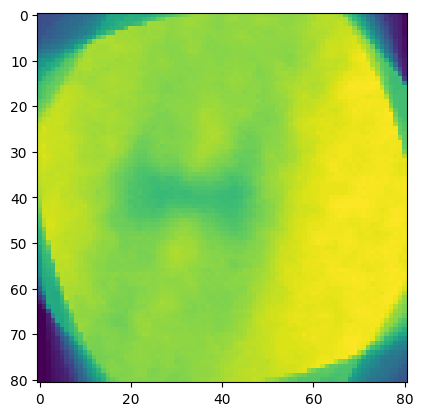

In [27]:
plt.imshow(composite_image[pad, :, :])

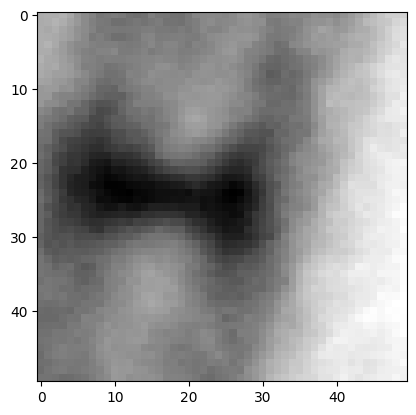

In [21]:
plt.imshow(
    composite_image[pad - 25 : pad + 25, pad, pad - 25 : pad + 25] / count,
    interpolation="None",
    cmap="gray",
)  # ,vmin=26,vmax=140)

In [66]:
np.sum(im == 0)

141561

In [44]:
ssim(im, first)

0.345168665805252

In [41]:
from skimage.metrics import structural_similarity as ssim

ssim(im, im)

1.0

In [70]:
pd_center, pd_start * 8, trans, roi.begin

(array([209008,  28264,  52208]),
 array([208946.96875   ,  28196.8046875 ,  52210.66015625]),
 array([-40.33251953, -31.60058594, -32.37109375]),
 (51888, 27944, 208688))

In [69]:
pd_start * 8, roi.begin

(array([208946.96875   ,  28196.8046875 ,  52210.66015625]),
 (51888, 27944, 208688))

In [221]:
np.linalg.norm([0, 2, 0])

2.0

In [23]:
import scipy

a = np.random.random((100, 100, 100))
im2 = scipy.ndimage.affine_transform(a, rot)

array([[[0.13217614, 0.03436011, 0.48445012, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.74471965, 0.51670868, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.75582204, 0.19582707, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.80849322, 0.28485224, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.48272313, 0.96036381, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.43811031, 0.61084556, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [6]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

/tmp/ipykernel_23291/3252285421.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image2 = scipy.ndimage.interpolation.rotate(


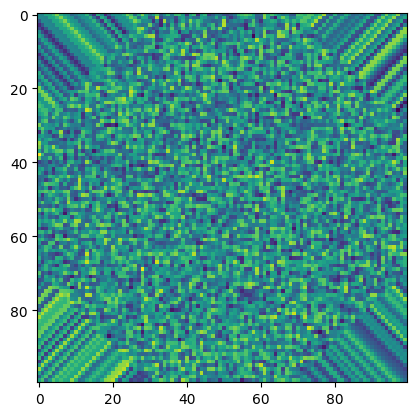

In [8]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

a = np.random.random((100, 100, 100))


image2 = scipy.ndimage.interpolation.rotate(
    a, 45, mode="nearest", axes=(0, 1), reshape=False
)
plt.imshow(image2[:, :, 1])

In [3]:
from funlib.evaluate import detection_scores
import numpy as np
gt = np.random.random_integers(0,255,(1500,1500,1500))
pred = np.random.random_integers(0,255,(1500,1500,1500))
detection_scores(gt,pred,matching_score="overlap", matching_threshold=1 )



/tmp/ipykernel_30931/3916696058.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  gt = np.random.random_integers(0,255,(1500,1500,1500))
/tmp/ipykernel_30931/3916696058.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  pred = np.random.random_integers(0,255,(1500,1500,1500))


MemoryError: Unable to allocate 25.0 GiB for an array with shape (3361827105,) and data type int64

In [4]:
gt.dtype

dtype('int64')